In [1]:
import numpy as np
import cv2
import glob
import json
import dlib
from imutils import face_utils
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from keras_vggface.vggface import VGGFace
from sklearn.decomposition import PCA, IncrementalPCA
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
# Load the dataset
with open('data_cleaned.json') as json_file:
    data_all = json.load(json_file)
# Extract the keys in sorted order
keys_all = sorted(data_all)
# Convert python list to np array
keys_all = np.asarray(keys_all)

In [3]:
participants = glob.glob('dataset/*')
# Define global variables
NUM_OF_PARTICIPANTS = len(participants)

In [29]:
### Uncomment to Use PCA for dimensionality reduction
# # features_all_scaled = ((features_all - features_all.mean(axis=0))/features_all.std(axis=0))

# n_comp = 32
# pca = PCA(n_components=n_comp)
# pca.fit(encodings_all)

# # ipca = IncrementalPCA(n_components=n_comp)
# # ipca.fit(features_all_scaled)

PCA(copy=True, iterated_power='auto', n_components=32, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [4]:
print("""Running attention prediction for {} participants and a total of {} images.
Each participant will be excluded from the training set once, our classifiers 
will be trained on the remaining participants and finally we will predict
the result for the one we left out. The total accuracy will be the mean value
of the accuracy of each participant""".format(NUM_OF_PARTICIPANTS, DATASET_SIZE))

Running attention prediction for 52 participants and a total of 2611 images.
Each participant will be excluded from the training set once, our classifiers 
will be trained on the remaining participants and finally we will predict
the result for the one we left out. The total accuracy will be the mean value
of the accuracy of each participant


In [4]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [37]:
# svm_classifier = svm.SVC(C=10, kernel='rbf', gamma='scale')
# features_train, features_val, labels_train, labels_val = train_test_split(features_all, labels_all, test_size=0.3)

# svm_classifier.fit(features_train, labels_train)

# y_pred_svm = svm_classifier.predict(features_val)

# print('Training set accuracy for SVM:', svm_classifier.score(features_train, labels_train))
# print('Test set accuracy for SVM: ', metrics.accuracy_score(labels_val, y_pred_svm))

Training set accuracy for SVM: 0.9768054823405377
Test set accuracy for SVM:  0.9138991389913899


In [5]:
with open('uuid_lengths_128.json') as json_file:
    uuid_lengths = json.load(json_file)

uuids = []
sum = 0
for i in range(NUM_OF_PARTICIPANTS):
    uuid = participants[i].split('/')[1]
    uuids.append(uuid)
    sum += uuid_lengths[uuid]
DATASET_SIZE = sum

In [6]:
print(sum)

2611


In [7]:
encodings_all = np.zeros((2611, 128))

#0 TEST SVM: 1.0, TRAIN SVM: 0.8910007757951901
[[33]]


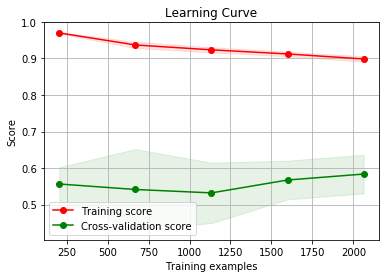

1.0


In [8]:
# Accuracy metrics for the whole dataset. These are computed
# by leaving every Subject out one time, calculating the accuracy for each
# one and then taking the mean value.
# accuracy_rf_total = 0
accuracy_svm_total = 0
# precision_rf_total = 0
# precision_svm_total = 0
# recall_rf_total = 0
# recall_svm_total = 0


# Array to keep track of subjects with low score
# low_score_subjects_rf = []
# low_score_subjects_svm = []

num_features = 128

dataset_len = 0
# Loop over each participant
for j in range(1):
    
    # Extract the UUID
    uuid_excluded = uuids[j]
    length_excluded = uuid_lengths[uuid_excluded]
    
    features_train = np.zeros((DATASET_SIZE  - length_excluded, num_features))
    features_val = np.zeros((length_excluded, num_features))
    labels_train = np.zeros(DATASET_SIZE - length_excluded)
    labels_val = np.zeros(length_excluded)
    
    start = 0
        
    for i in range(NUM_OF_PARTICIPANTS):
        uuid = uuids[i]
        length = uuid_lengths[uuid]

        features = np.load('encodings_128/encodings_' + uuid + '.npy')
        labels = np.load('encodings_128/labels_' + uuid + '.npy')
#         encodings_all[start:start+length, :] = features
#         start += length
#         continue
        
#         features = pca.transform(features)
        
#         hand_features = np.load('leave_one_out_datasets/X_' + uuid + '.npy')
#         hand_labels = np.load('leave_one_out_datasets/y_' + uuid + '.npy')
        
        if uuid == uuid_excluded:
            if features.shape[0] != length:
                print('Error')
            features_val = features
            labels_val = labels
        else:
            if features.shape[0] != length:
                print('Error 2')
                print(features.shape[0], length, j, i)
                break
            features_train[start : start + length] = features
            labels_train[start : start + length] = labels
            start += length
    classifier = svm.SVC(C=10, kernel='rbf', gamma='scale')
    classifier.fit(features_train, labels_train)
    
#     classifier = RandomForestClassifier(n_estimators=100, random_state=1)
#     classifier.fit(features_train, labels_train)
    
    y_pred_svm = classifier.predict(features_val)
#     y_pred_rf = rf_classifier.predict(features_val)
    confusion_matrix_svm = metrics.confusion_matrix(labels_val, y_pred_svm)
    
    accuracy_svm_subject = metrics.accuracy_score(labels_val, y_pred_svm)
    accuracy_svm_total += accuracy_svm_subject*y_pred_svm.shape[0]
    dataset_len += y_pred_svm.shape[0]
    
    print('#{} TEST SVM: {}, TRAIN SVM: {}'.format(j, round(accuracy_svm_subject, 2),
                                      round(classifier.score(features_train, labels_train), 2)))
    print(confusion_matrix_svm)
    plot_learning_curve(classifier,'Learning Curve',  features_train, labels_train, cv=5)
    plt.show()
print(accuracy_svm_total/dataset_len)

In [9]:
print(y_pred_svm)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [10]:
print(uuid_excluded)

0656f5fe35a54d1589e526a702f578b0
